In [25]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_financial_data(ticker):
    stock = yf.Ticker(ticker)
    #income statement
    ic = stock.financials.T
    #balance sheet
    bs = stock.balance_sheet.T
    #cash flow statement
    cf = stock.cashflow.T
    return ic, bs, cf

In [3]:
#t1 = year (t-1)
"""
Mscore = –4.84 + 0.92*DSRI + 0.528*GMI + 0.404*AQI + 0.892*SGI + 0.115*DEPI – 0.172*SGAI – 0.372*LVGI + 4.679*TATA.

Results:
-1.78 or higher: likely manipulater
-2 or below: unlikely manipulater
oterwise: undecided
"""
##if > 1(+): sales inflation
def DSRI(receivables_t, sales_t, receivables_t1, sales_t1):
    return (receivables_t / sales_t) / (receivables_t1 / sales_t1)

##if > 1 (+): indication of deterioating margin (-> greater incentive to manipulate)
def GMI(sales_t1, cogs_t1, sales_t, cogs_t):
    gross_margin_t1 = (sales_t1 - cogs_t1) / sales_t1
    gross_margin_t = (sales_t - cogs_t) / sales_t
    return gross_margin_t1 / gross_margin_t

##if > 1 (+): improper deferring of costs
def AQI(noncurr_assets_t, ppe_t, total_assets_t, noncurr_assets_t1, ppe_t1, total_assets_t1):
    asq_t = (noncurr_assets_t - ppe_t) / total_assets_t
    asq_t1 = (noncurr_assets_t1 - ppe_t1) / total_assets_t1
    return asq_t/asq_t1

##if > 1 (+): greater incentive to manipulate
def SGI(sales_t, sales_t1):
    return sales_t / sales_t1

##if > 1 (+): less depreciation -> likely adjustment(manipulation) to estimate life(core accounting assumption) to inflate net income
##ppe is NET PPE
def DEPI(dep_t, ppe_t, dep_t1, ppe_t1):
    dep_rate_t = dep_t / (dep_t + ppe_t)
    dep_rate_t1 = dep_t1 / (dep_t1 + ppe_t1)
    return dep_rate_t1 / dep_rate_t

##if < 1 (-): likely inflation of sales
def SGAI(sga_t, sales_t, sga_t1, sales_t1):
    sga_index_t = sga_t / sales_t
    sga_index_t1 = sga_t1 / sales_t1
    return sga_index_t / sga_index_t1

##if > 1 (+): likely manipulation to meet the debt covenants
##however, the effect may not be significant becasue 
def LVGI(total_debt_t, total_assets_t, total_debt_t1, total_assets_t1):
    levg_t = total_debt_t / total_assets_t
    levg_t1 = total_debt_t1 / total_assets_t1
    return levg_t / levg_t1

##if > 1 (+): accural income not backed up by actual cashflow -> likely manipulation
def TATA(net_inc, ocf, total_assets):
    return (net_inc - ocf) / total_assets



In [10]:
# ticker list
Tickers = ["AAPL"]

data = []

for ticker in Tickers:

    
    ic, bs, cf = get_financial_data(ticker)

    for j in range(3):
        
        
        # Extract relevant data
        sales_t = ic.get('Total Revenue', pd.Series([np.nan, np.nan])).iloc[0 + j]
        sales_t1 = ic.get('Total Revenue', pd.Series([np.nan, np.nan])).iloc[1 + j]
    
        cogs_t1 = ic.get('Cost Of Revenue', pd.Series([np.nan, np.nan])).iloc[1 + j]
        cogs_t = ic.get('Cost Of Revenue', pd.Series([np.nan, np.nan])).iloc[0 + j]
    
        
        net_income = ic.get('Net Income', pd.Series([np.nan, np.nan])).iloc[0 + j]
        operating_cash_flow = cf.get('Operating Cash Flow', pd.Series([np.nan, np.nan])).iloc[0 + j]
        
        receivables_t = bs.get('Accounts Receivable', pd.Series([np.nan, np.nan])).iloc[0 + j]
        receivables_t1 = bs.get('Accounts Receivable', pd.Series([np.nan, np.nan])).iloc[1 + j]
            
        ppe_t = bs.get('Net PPE', pd.Series([np.nan, np.nan])).iloc[0 + j]
        noncurr_assets_t = bs.get('Total Non Current Assets', pd.Series([np.nan, np.nan])).iloc[0 + j]
        total_assets_t = bs.get('Total Assets', pd.Series([np.nan, np.nan])).iloc[0 + j]
        
        ppe_t1 = bs.get('Net PPE', pd.Series([np.nan, np.nan])).iloc[1 + j]
        noncurr_assets_t1 = bs.get('Total Non Current Assets', pd.Series([np.nan, np.nan])).iloc[1 + j]
        total_assets_t1 = bs.get('Total Assets', pd.Series([np.nan, np.nan])).iloc[1 +j]
    
        dep_t = cf.get('Depreciation Amortization Depletion', pd.Series([np.nan, np.nan])).iloc[0 + j]
        dep_t1 = cf.get('Depreciation Amortization Depletion', pd.Series([np.nan, np.nan])).iloc[1 + j]
    
        #####
        sga_t = ic.get('Operating Expense', pd.Series([np.nan, np.nan])).iloc[0 + j]
        sga_t1 = ic.get('Operating Expense', pd.Series([np.nan, np.nan])).iloc[0 + j]
        ####
        
        total_debt_t = bs.get('Total Debt', pd.Series([np.nan, np.nan])).iloc[0 + j]
        total_debt_t1 = bs.get('Total Debt', pd.Series([np.nan, np.nan])).iloc[1 + j]
        
        dsri = DSRI(receivables_t, sales_t, receivables_t1, sales_t1)
        gmi = GMI(sales_t1, cogs_t1, sales_t, cogs_t)
        aqi = AQI(noncurr_assets_t, ppe_t, total_assets_t, noncurr_assets_t1, ppe_t1, total_assets_t1)
        sgi = SGI(sales_t, sales_t1)
        depi = DEPI(dep_t, ppe_t, dep_t1, ppe_t1)
        sgai = SGAI(sga_t, sales_t, sga_t1, sales_t1)
        tata = TATA(net_income, operating_cash_flow, total_assets_t)
        lvgi = LVGI(total_debt_t, total_assets_t, total_debt_t1, total_assets_t1)
    
        # Append to the dataset 
        data.append([ticker, 2023 - j, dsri, gmi, aqi, sgi, depi, sgai, tata, lvgi])


In [11]:
# Create DataFrame 
columns = ["Company Ticker", "Year", "DSRI", "GMI", "AQI", "SGI", "DEPI", "SGAI", "TATA", "LVGI"]
Tickers_df = pd.DataFrame(data, columns=columns)

In [12]:
# Display the dataset
Tickers_df

,Company Ticker,Year,DSRI,GMI,AQI,SGI,DEPI,SGAI,TATA,LVGI
0,AAPL,2023,1.077142,0.981385,0.943787,0.971995,1.000433,1.028811,-0.038425,0.925653
1,AAPL,2022,0.994985,0.964667,0.986624,1.077938,1.066236,0.927697,-0.063353,0.957932
2,AAPL,2021,1.223290,0.915123,1.137128,1.332594,1.039252,0.750416,-0.026661,1.023558


In [18]:
"""
Mscore = –4.84 + 0.92*DSRI + 0.528*GMI + 0.404*AQI + 0.892*SGI + 0.115*DEPI – 0.172*SGAI – 0.372*LVGI + 4.679*TATA.

Results:
-1.78 or higher: likely manipulater
-2 or below: unlikely manipulater
oterwise: undecided
"""

Tickers_df['M-score'] = -4.84 + 0.92 * Tickers_df['DSRI'] + 0.528 * Tickers_df['GMI'] + 0.404 * Tickers_df['AQI'] + 0.892 * Tickers_df['SGI'] + 0.115 * Tickers_df['DEPI'] - 0.172 * Tickers_df['SGAI'] - 0.372 * Tickers_df['LVGI'] + 4.679 * Tickers_df['TATA']

In [19]:
Tickers_df

,Company Ticker,Year,DSRI,GMI,AQI,SGI,DEPI,SGAI,TATA,LVGI,M-score
0,AAPL,2023,1.077142,0.981385,0.943787,0.971995,1.000433,1.028811,-0.038425,0.925653,-2.668587
1,AAPL,2022,0.994985,0.964667,0.986624,1.077938,1.066236,0.927697,-0.063353,0.957932,-2.744878
2,AAPL,2021,1.223290,0.915123,1.137128,1.332594,1.039252,0.750416,-0.026661,1.023558,-2.098382


In [22]:
# Plotting function
def plot_m_score(ticker, df):
    df_ticker = df[df['Company Ticker'] == ticker]
    plt.figure(figsize=(10, 6))
    plt.plot(df_ticker['Year'], df_ticker['M-score'], marker='o')
    plt.xlabel('Year')
    plt.ylabel('M-score')
    plt.title(f'{ticker} M-score')
    plt.grid(True)
    plt.show()


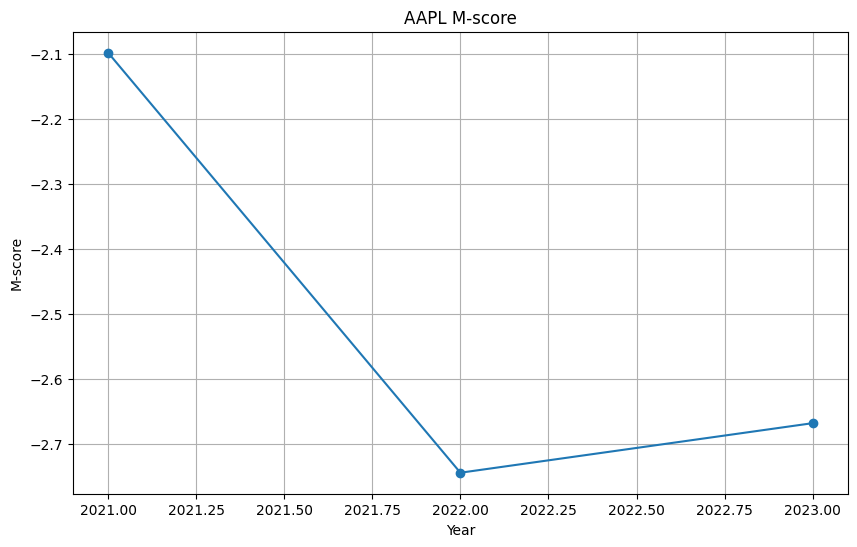

In [26]:
# Plot the M-score for the given ticker
plot_m_score("AAPL", Tickers_df)